# Red Neuronal para Clasificación no Lineal

In [24]:
!pip install ipympl

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from _collections_abc import Callable
from google.colab import output

%matplotlib inline
%matplotlib widget
output.enable_custom_widget_manager()

Cree los datos de entrada y sus etiquetas:

In [2]:
#Generate entry data via function
def get_data(xo:float = 1.2, yo:float = 0.3, quantity:int = 5000, a:float = 1.4, b:float = 0.3) -> list[tuple[tuple[float,float],float]]:
  prevTuple:tuple[float,float] = (xo, yo)
  data:list[tuple[tuple[float,float],float]] = []
  for i in range(quantity):
    next_x:float = 1 - a*np.power(prevTuple[0],2) + prevTuple[1]
    next_y:float = b*prevTuple[0]
    data.append( (prevTuple, next_x) ) #Create pairs {(xn, yn), xn+1}
    prevTuple = (next_x, next_y)
  return data

#Generate and split data
full_data = get_data()
random.shuffle(full_data)
separator = round(len(full_data)*0.7)
train_data = full_data[:separator] #Obtener los primeros elementos (~70% de data)
validation_data = full_data[separator:] #Obtener el resto (~30% de data)

#Assign training data and their tags
X = [data[0] for data in train_data]
y = [data[1] for data in train_data]

Para una red neuronal con dos neuronas en la capa de entrada, dos en la capa escondida y una en la salida, inicialize los pesos y sesgos:

In [3]:
w1 = [2 * random.random() - 1, 2 * random.random() - 1]
w2 = [2 * random.random() - 1, 2 * random.random() - 1]
w3 = [2 * random.random() - 1, 2 * random.random() - 1]

b1 = 2 * random.random() - 1
b2 = 2 * random.random() - 1
b3 = 2 * random.random() - 1

eta = 0.1

Defina la función de activación y su derivada:

In [4]:
def sigmoid(x):
    # Definicion de la función sigmoide
    return 1/(1 + math.exp(-x))

def dsigmoid(y): #Entrada: y = sigmoid(x)
    # Definicion de la derivada de la función sigmoide
    return y*(1 - y)


## Forward pass

In [5]:
def forward_step(inputs: list[float], weights: list[float], bias: float, activation_func: Callable[[float], float]) -> tuple[float, float]:
  y_predict = np.dot(inputs, weights) + bias

  return (activation_func(y_predict), y_predict)

## Backward pass

Implemente las derivadas del error respecto a los parámetros w y b:

In [6]:
#Returns list as follows: w11, w12, w21, w22, w31, w32, b1, b2, b3
#To-do make derivative of activation an injectable parameter instead of fixed
def get_derivatives(X:tuple[float, float], y:float, y_pred:float, Z:tuple[float,float,float], A:tuple[float,float]) -> list[float]:
  global w1, w2, w3, b1, b2, b3
  dE_w31 = (-1)*(y - y_pred)*(y_pred)*(1 - y_pred)*A[0]
  dE_w32 = (-1)*(y - y_pred)*(y_pred)*(1 - y_pred)*A[1]
  dE_b3 = (-1)*(y - y_pred)*(y_pred)*(1 - y_pred)*1
  dE_w21 = ( (-1)*(y - y_pred)*(y_pred)*(1 - y_pred) ) * (w3[1]) * dsigmoid(Z[1]) * X[0]
  dE_w22 = ( (-1)*(y - y_pred)*(y_pred)*(1 - y_pred) ) * (w3[1]) * dsigmoid(Z[1]) * X[1]
  dE_b2 = ( (-1)*(y - y_pred)*(y_pred)*(1 - y_pred) ) * (w3[1]) * dsigmoid(Z[1]) * 1
  dE_w11 = ( (-1)*(y - y_pred)*(y_pred)*(1 - y_pred) ) * (w3[0]) * dsigmoid(Z[0]) * X[0]
  dE_w12 = ( (-1)*(y - y_pred)*(y_pred)*(1 - y_pred) ) * (w3[0]) * dsigmoid(Z[0]) * X[1]
  dE_b1 = ( (-1)*(y - y_pred)*(y_pred)*(1 - y_pred) ) * (w3[0]) * dsigmoid(Z[0]) * 1
  result = [dE_w11, dE_w12, dE_w21, dE_w22, dE_w31, dE_w32, dE_b1, dE_b2, dE_b3]
  return result


Implemente la correción de los parámetros:

In [7]:
#NOTE. This will modify global weights and biases according to last forward pass
def backward_pass(error:float, learn_rate:float, input:list[float], y:float, y_pred:float, Z:tuple[float,float,float], A:tuple[float,float]):
  global w1, w2, w3, b1, b2, b3
  derivatives = get_derivatives(tuple(input), y, y_pred, Z, A)
  w1 = (w1[0] - learn_rate * derivatives[0], w1[1] - learn_rate * derivatives[1])
  w2 = (w2[0] - learn_rate * derivatives[2], w2[1] - learn_rate * derivatives[3])
  w3 = (w3[0] - learn_rate * derivatives[4], w3[1] - learn_rate * derivatives[5])
  b1 = b1 - learn_rate * derivatives[6]
  b2 = b2 - learn_rate * derivatives[7]
  b3 = b3 - learn_rate * derivatives[8]

## Entrenamiento de la red neuronal

Use el esquema de "Retropropagación" para entrenar la red.

In [8]:
# Implementación de la retropropagación

Valide del entrenamiento. Con una gráfica del error en funcion de las épocas.

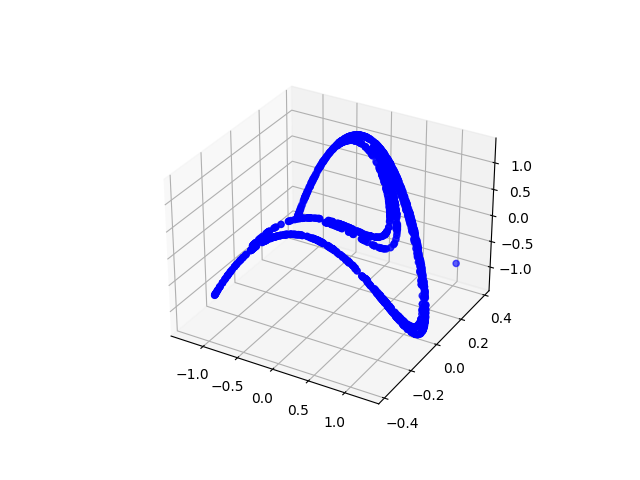

In [30]:
# Gráfica Error vs. Épocas
x: list[float] = []
y: list[float] = []
labels: list[float] = []
for i in range(0, len(validation_data)):
  x.append(validation_data[i][0][0])
  y.append(validation_data[i][0][1])
  labels.append(validation_data[i][1])

grafica = plt.figure().add_subplot(projection = "3d")
grafica.scatter(x, y, labels, color = "blue")
plt.show()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()